# Prevendo qual o tipo de uma proteíno de acordo com dados experimentais

O objetivo desse trabalho é construir um modelo de decisão que, tenha o poder de retornar qual a provavel classificação da proteína.

 Nesse notebook temos:
 - Carga e tratamento dos dados
 - Desenvolvimento e teste do modelo de decisão
 - Tunning de hyperparâmetros do melhor modelo
 - Serialização do melhor modelo

In [60]:
import os
import zipfile
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pickle

In [61]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
appPath = os.path.join(rootPath, 'app')

# 01. Importando e avaliando os dados

In [62]:
# Função que tira os dados do zip e le o csv contido
def ler_bases(nome_zip, nome_csv):
    zip_file = os.path.join(dataPath, nome_zip)
    z = zipfile.ZipFile(zip_file)
    z.extract(nome_csv)
    df = pd.read_csv(nome_csv)
    os.remove(nome_csv)
    return df

In [63]:
data1 = ler_bases('dados.zip', 'pdb_data_no_dups.csv')
data2 = ler_bases('dados.zip', 'pdb_data_seq.csv')

In [64]:
data1.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [65]:
data2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [66]:
# União dos dataframes pelo structureId

data = pd.merge(data1, data2, on='structureId')
data.set_index('structureId').head()

,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
structureId,,,,,,,,,,,,,,,,,
100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG,20,DNA/RNA Hybrid
101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG,24,DNA
101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


# 02. Limpando os Dados

In [67]:
# Limpeza dos dados
# Retirando simbolos para facilitar a identificação

data["classification"]=data["classification"].str.replace('\n','')
data["classification"]=data["classification"].str.replace('\r','')
data["classification"]=data["classification"].str.replace('-','')
data["classification"]=data["classification"].str.replace(',','')
data["classification"]=data["classification"].str.replace('/','')
data["classification"]=data["classification"].str.replace(' ','')
data["classification"]
data['classification'].unique()


data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('\n','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('\r','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('-','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace(',','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace('/','')
data["experimentalTechnique"]=data["experimentalTechnique"].str.replace(' ','')
data["experimentalTechnique"]

0         XRAYDIFFRACTION
1         XRAYDIFFRACTION
2         XRAYDIFFRACTION
3         XRAYDIFFRACTION
4         XRAYDIFFRACTION
               ...       
471144    XRAYDIFFRACTION
471145    XRAYDIFFRACTION
471146    XRAYDIFFRACTION
471147    XRAYDIFFRACTION
471148    XRAYDIFFRACTION
Name: experimentalTechnique, Length: 471149, dtype: object

In [68]:
data.describe()

,residueCount_x,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,residueCount_y
count,471149.00000,449486.000000,4.711490e+05,317697.000000,389645.000000,389768.000000,340694.000000,413513.000000,471149.00000
mean,6257.93182,3.020658,9.261153e+05,290.889746,2.850779,54.198949,6.830608,2010.483702,6257.93182
std,23618.38381,3.091223,3.018842e+06,8.785254,0.824394,10.269884,2.461778,6.997897,23618.38381
min,0.00000,0.480000,4.535500e+02,4.000000,0.000000,0.000000,0.000000,201.000000,0.00000
25%,456.00000,2.000000,5.276684e+04,291.000000,2.320000,46.890000,6.100000,2007.000000,456.00000
50%,1140.00000,2.500000,1.311385e+05,293.000000,2.670000,53.950000,7.000000,2012.000000,1140.00000
75%,4528.00000,3.100000,6.353231e+05,295.000000,3.190000,61.370000,7.500000,2015.000000,4528.00000
max,313236.00000,70.000000,9.773054e+07,398.000000,99.000000,92.000000,724.000000,2018.000000,313236.00000


In [69]:
print("O datasete contem", data.shape[0], "observações")

O datasete contem 471149 observações


In [70]:
# Detectando valores vazios

data.isnull().sum()

structureId                      0
classification                   4
experimentalTechnique            0
macromoleculeType_x          35770
residueCount_x                   0
resolution                   21663
structureMolecularWeight         0
crystallizationMethod       156395
crystallizationTempK        153452
densityMatthews              81504
densityPercentSol            81381
pdbxDetails                  85681
phValue                     130455
publicationYear              57636
chainId                         10
sequence                        28
residueCount_y                   0
macromoleculeType_y          35770
dtype: int64

In [71]:
# Retirando valroes vazios e variáveis irrelevantes para o modelo

data2 = data.dropna(how='any')
data_clean = data2.drop(columns= ['publicationYear', 'chainId','macromoleculeType_x', 'macromoleculeType_y', 'pdbxDetails']).set_index('structureId')
data_clean.head()

,classification,experimentalTechnique,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence,residueCount_y
structureId,,,,,,,,,,,,
102D,DNA,XRAYDIFFRACTION,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,7.0,CGCAAATTTGCG,24
102D,DNA,XRAYDIFFRACTION,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,7.0,CGCAAATTTGCG,24
110D,DNA,XRAYDIFFRACTION,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,2.90,57.63,6.6,CGGCCG,6
111D,DNA,XRAYDIFFRACTION,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,6.6,CGCAAATTGGCG,24
111D,DNA,XRAYDIFFRACTION,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,6.6,CGCAAATTGGCG,24


In [72]:
data_clean.isnull().sum()

classification              0
experimentalTechnique       0
residueCount_x              0
resolution                  0
structureMolecularWeight    0
crystallizationMethod       0
crystallizationTempK        0
densityMatthews             0
densityPercentSol           0
phValue                     0
sequence                    0
residueCount_y              0
dtype: int64

# 03. Visualizando as variáveis presentes

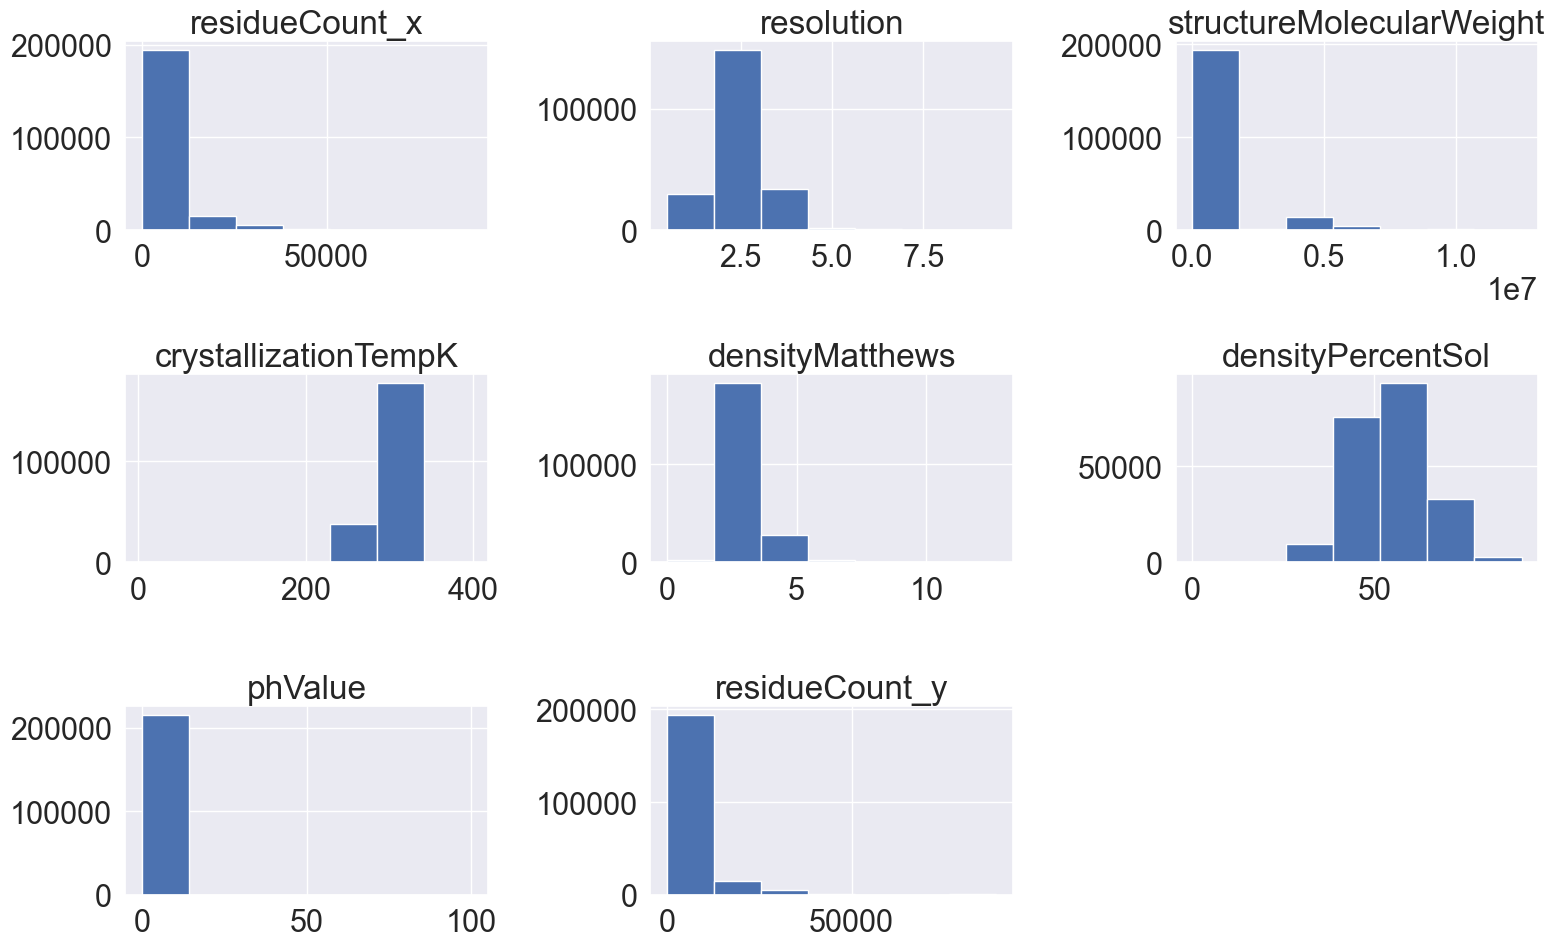

In [73]:
data_clean.hist(bins=7, figsize=(16, 10))
plt.tight_layout()

<Axes: xlabel='phValue', ylabel='count'>

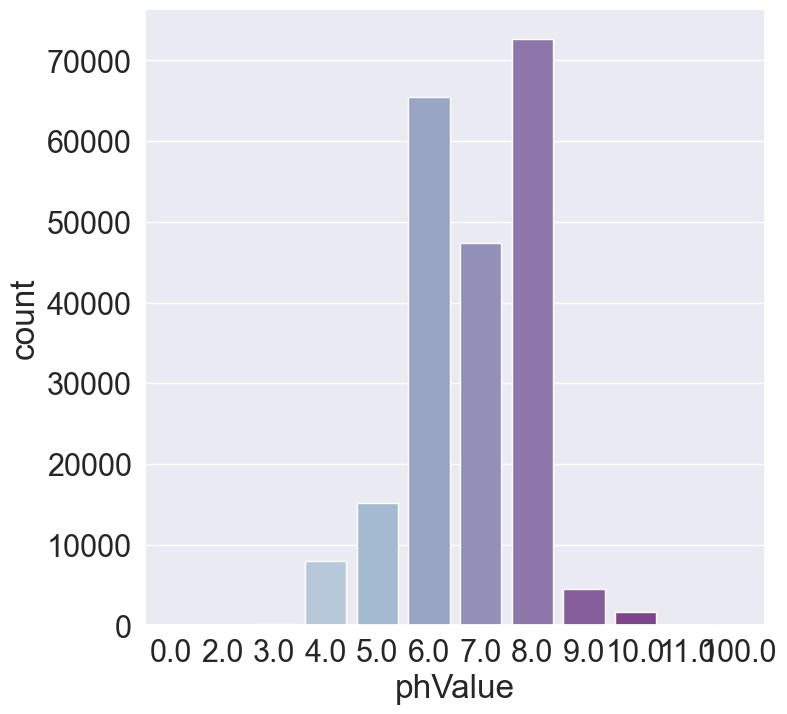

In [74]:
# Explorando os valores de pH para entender melhor a distribuição

plt.figure(figsize=(8,8))
sns.countplot(data=data_clean, x=data_clean['phValue'].round(), palette='BuPu')

<Axes: xlabel='classification'>

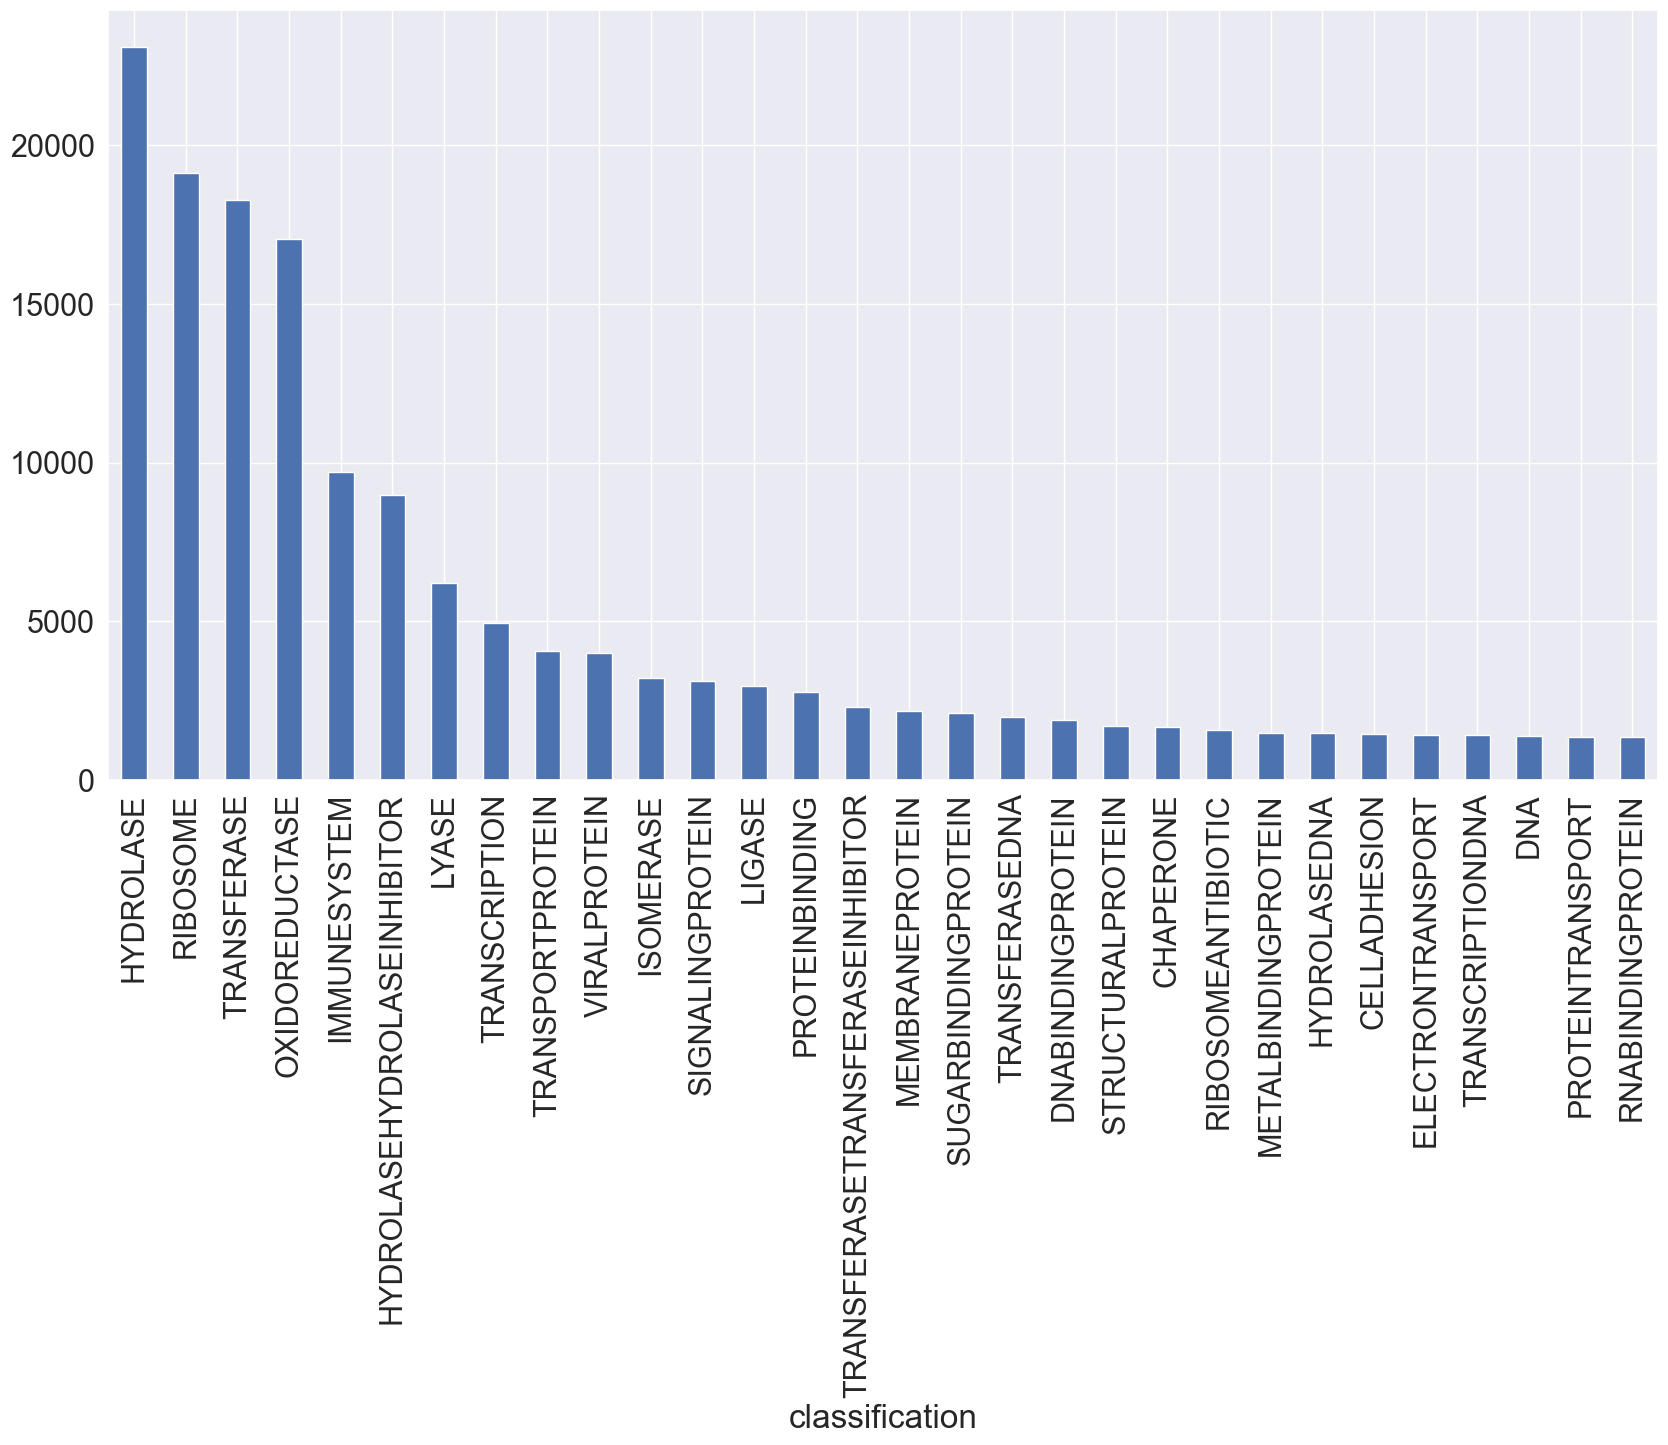

In [75]:
# Contagem de valores da variável target
# Filtrando as 30 classificações que mais aparecem no dataset


plt.figure(figsize=(20,10))
data_clean['classification'].value_counts()[:30].plot(kind='bar')

In [76]:
data_clean

,classification,experimentalTechnique,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence,residueCount_y
structureId,,,,,,,,,,,,
102D,DNA,XRAYDIFFRACTION,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.00,2.28,46.06,7.0,CGCAAATTTGCG,24
102D,DNA,XRAYDIFFRACTION,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.00,2.28,46.06,7.0,CGCAAATTTGCG,24
110D,DNA,XRAYDIFFRACTION,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.00,2.90,57.63,6.6,CGGCCG,6
111D,DNA,XRAYDIFFRACTION,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.00,2.29,46.25,6.6,CGCAAATTGGCG,24
111D,DNA,XRAYDIFFRACTION,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.00,2.29,46.25,6.6,CGCAAATTGGCG,24
...,...,...,...,...,...,...,...,...,...,...,...,...
6FAH,FLAVOPROTEIN,XRAYDIFFRACTION,2074,3.13,231360.91,"VAPOR DIFFUSION, SITTING DROP",293.15,3.49,64.73,8.5,MYFSEQNKMIRKLARDFAEKELTTEILDEVEESGEFPQEILDKMAK...,2074
6FAH,FLAVOPROTEIN,XRAYDIFFRACTION,2074,3.13,231360.91,"VAPOR DIFFUSION, SITTING DROP",293.15,3.49,64.73,8.5,MAIKVIEEKCIGCSKCQKSCPFDAITIENKIAVIGDACTNCGTCID...,2074
6FAH,FLAVOPROTEIN,XRAYDIFFRACTION,2074,3.13,231360.91,"VAPOR DIFFUSION, SITTING DROP",293.15,3.49,64.73,8.5,MRILVCAKQVPDTNEVKIDPKTGTMIREGVPSILNPDDANALEAAL...,2074


# 04. Preparando o dataframe usado para o modelo

In [77]:
# Variáveis com alta correlação entre elas: residueCount_y, residueCount_x, desntiyMatthews, densityPercentSol

data_new = data_clean.drop(columns = ['residueCount_y', 'residueCount_x', 'densityMatthews', 'densityPercentSol'])

In [78]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215142 entries, 102D to 7BNA
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   classification            215142 non-null  object 
 1   experimentalTechnique     215142 non-null  object 
 2   resolution                215142 non-null  float64
 3   structureMolecularWeight  215142 non-null  float64
 4   crystallizationMethod     215142 non-null  object 
 5   crystallizationTempK      215142 non-null  float64
 6   phValue                   215142 non-null  float64
 7   sequence                  215142 non-null  object 
dtypes: float64(4), object(4)
memory usage: 22.8+ MB


In [79]:
print("Quantidade de valores únicos para Classificação:", data_new['classification'].unique().shape[0])
print("Quantidade de valores únicos para Técnica experimental:", data_new['experimentalTechnique'].unique().shape[0])
print("Quantidade de valores únicos para Método de cristalização:", data_new['crystallizationMethod'].unique().shape[0])
print("Quantidade de valores únicos para Sequência:", data_new['sequence'].unique().shape[0])

Quantidade de valores únicos para Classificação: 2231
Quantidade de valores únicos para Técnica experimental: 9
Quantidade de valores únicos para Método de cristalização: 406
Quantidade de valores únicos para Sequência: 49952


In [80]:
# Retirar sequência e método de cristalização do modelo, para reduzir processamento

data_model = data_new.drop(columns=['crystallizationMethod', 'sequence'])

In [81]:
# Transformando os valores textuais de experimentalTechnique valores numéricos

data_model['experimentalTechnique'].unique()

array(['XRAYDIFFRACTION', 'POWDERDIFFRACTION', 'ELECTRONCRYSTALLOGRAPHY',
       'NEUTRONDIFFRACTION', 'XRAYDIFFRACTIONEPR', 'EPRXRAYDIFFRACTION',
       'NEUTRONDIFFRACTIONXRAYDIFFRACTION',
       'XRAYDIFFRACTIONNEUTRONDIFFRACTION',
       'SOLUTIONSCATTERINGXRAYDIFFRACTION'], dtype=object)

In [82]:
metodo_experimental = {
    'XRAYDIFFRACTION': 0,
    'POWDERDIFFRACTION': 1, 
    'ELECTRONCRYSTALLOGRAPHY': 2,
    'NEUTRONDIFFRACTION': 3, 
    'XRAYDIFFRACTIONEPR': 4, 
    'EPRXRAYDIFFRACTION': 5,
    'NEUTRONDIFFRACTIONXRAYDIFFRACTION': 6,
    'XRAYDIFFRACTIONNEUTRONDIFFRACTION': 7,
    'SOLUTIONSCATTERINGXRAYDIFFRACTION': 8
}

data_model['experimentalTechnique'] = data_model['experimentalTechnique'].map(metodo_experimental)
data_model.head()

,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
structureId,,,,,,
102D,DNA,0,2.20,7637.17,277.0,7.0
102D,DNA,0,2.20,7637.17,277.0,7.0
110D,DNA,0,1.90,2337.73,277.0,6.6
111D,DNA,0,2.25,7374.83,277.0,6.6
111D,DNA,0,2.25,7374.83,277.0,6.6


In [83]:
# Por serem 2231 tipos distintos de classificações, aqui serão tratados apenas as 5 classificações mais frequentes

data_clean['classification'].value_counts()[:5]

classification
HYDROLASE         23115
RIBOSOME          19120
TRANSFERASE       18270
OXIDOREDUCTASE    17037
IMMUNESYSTEM       9712
Name: count, dtype: int64

In [84]:
# Filtrando o dataset para ter só as 5 classificações acima

data_final = data_model.query("classification == ['HYDROLASE', 'RIBOSOME', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNESYSTEM']")
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87254 entries, 1A72 to 6F6P
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   classification            87254 non-null  object 
 1   experimentalTechnique     87254 non-null  int64  
 2   resolution                87254 non-null  float64
 3   structureMolecularWeight  87254 non-null  float64
 4   crystallizationTempK      87254 non-null  float64
 5   phValue                   87254 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.7+ MB


In [85]:
data_final.head()

,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
structureId,,,,,,
1A72,OXIDOREDUCTASE,0,2.6,40658.50,277.0,8.40
1AR4,OXIDOREDUCTASE,0,1.9,45428.53,277.0,6.10
1AR4,OXIDOREDUCTASE,0,1.9,45428.53,277.0,6.10
1AR5,OXIDOREDUCTASE,0,1.6,45430.34,277.0,6.15
1AR5,OXIDOREDUCTASE,0,1.6,45430.34,277.0,6.15


In [86]:
print("Total de observações no dataframe final:", data_final.shape[0])
print("Total de observações no dataframe inicial:", data.shape[0])

Total de observações no dataframe final: 87254
Total de observações no dataframe inicial: 471149


# 05. Visualizando a variável target (classificação das proteinas)

In [87]:
data_final.groupby(['classification']).mean()

,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
classification,,,,,
HYDROLASE,0.002336,2.203503,1.883575e+05,291.531658,6.680285
IMMUNESYSTEM,0.000000,2.469973,1.334074e+05,291.834468,6.702368
OXIDOREDUCTASE,0.000000,2.201284,2.158153e+05,290.680061,6.792723
RIBOSOME,0.000000,3.338800,4.480948e+06,287.199979,7.129237
TRANSFERASE,0.000219,2.344500,1.925363e+05,291.053973,6.852540


<Axes: title={'center': 'Distribuição da variável Reslution'}, xlabel='classification', ylabel='resolution'>

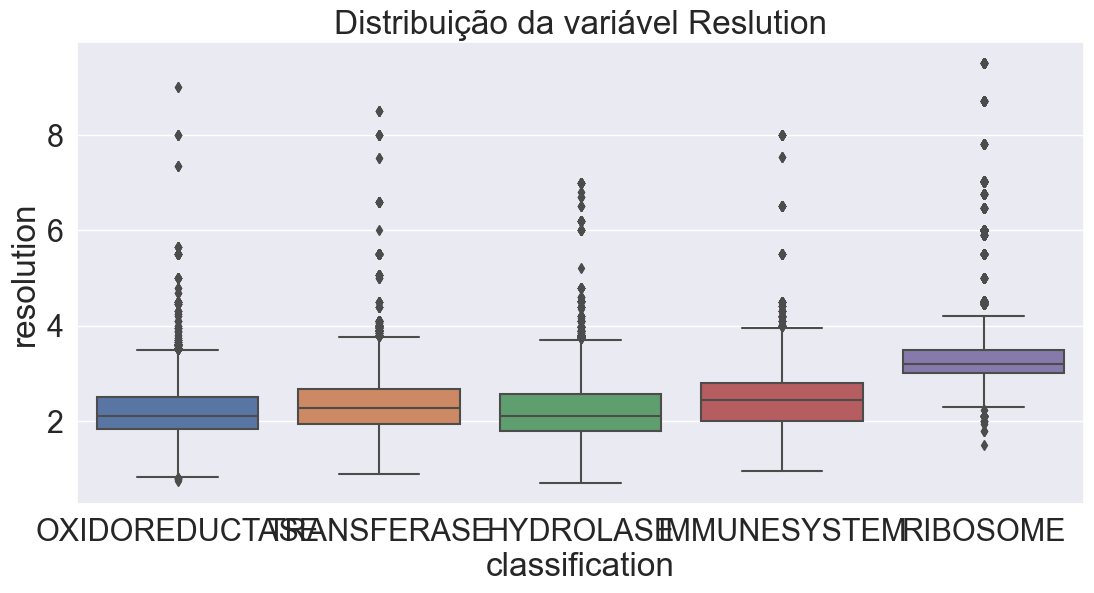

In [88]:
plt.figure(figsize=(13,6))
plt.title('Distribuição da variável Reslution')
sns.boxplot(x=data_final['classification'], y=data_final['resolution'], orient='v')

<Axes: title={'center': 'Distribuição do Peso da estrutura molecular'}, xlabel='classification', ylabel='structureMolecularWeight'>

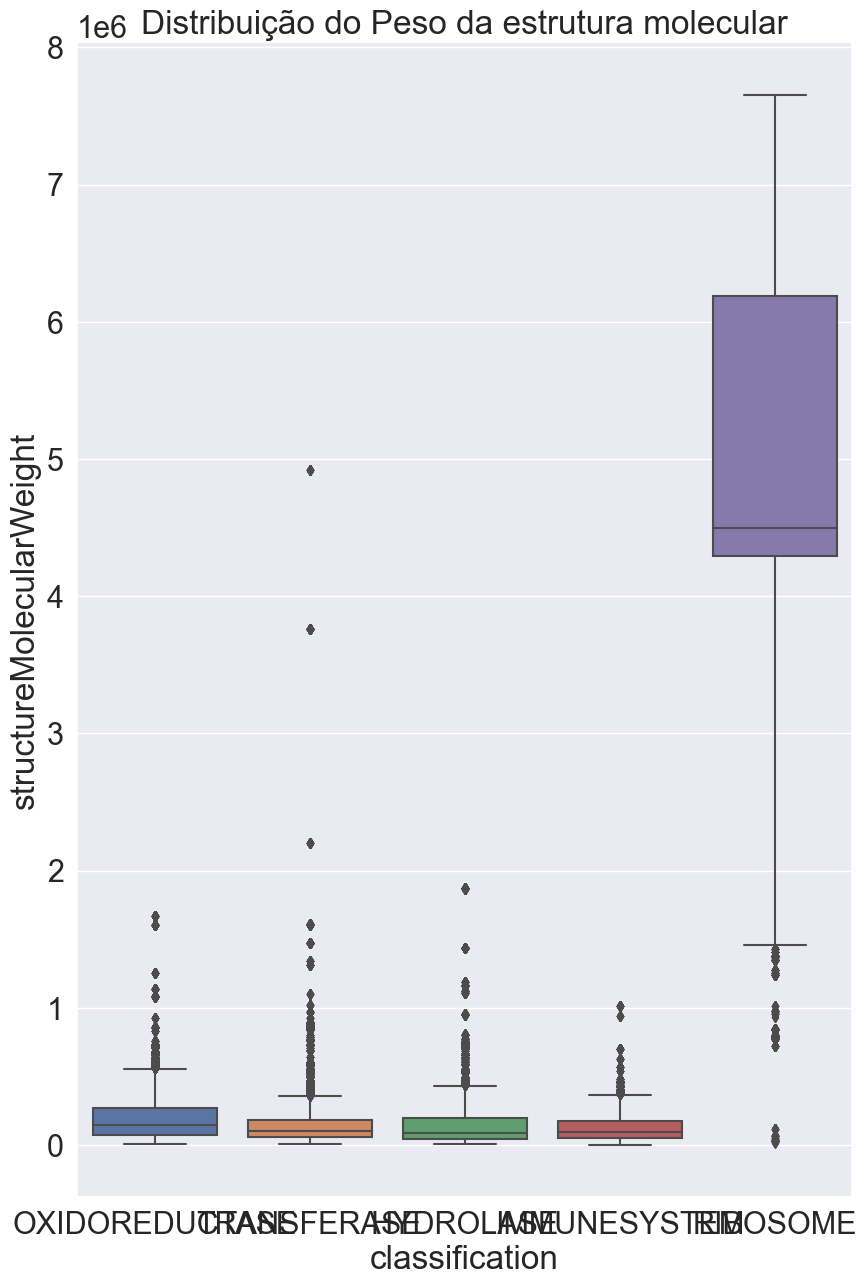

In [89]:
plt.figure(figsize=(10,15))
plt.title('Distribuição do Peso da estrutura molecular')
sns.boxplot(x=data_final['classification'], y=data_final['structureMolecularWeight'], orient='v')

<Axes: title={'center': 'Distribuição da temperatura de cristalização (em K)'}, xlabel='classification', ylabel='crystallizationTempK'>

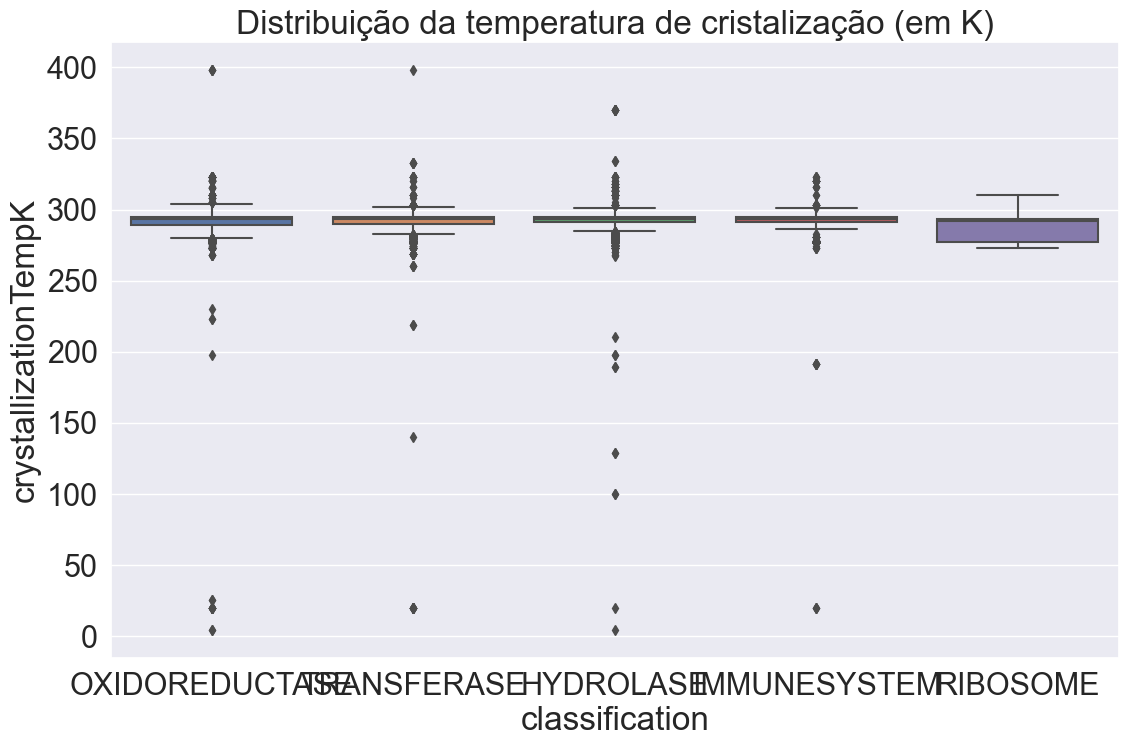

In [90]:
plt.figure(figsize=(13,8))
plt.title('Distribuição da temperatura de cristalização (em K)')
sns.boxplot(x=data_final['classification'], y=data_final['crystallizationTempK'], orient='v')

<Axes: title={'center': 'Distribuição do valor de pH'}, xlabel='classification', ylabel='phValue'>

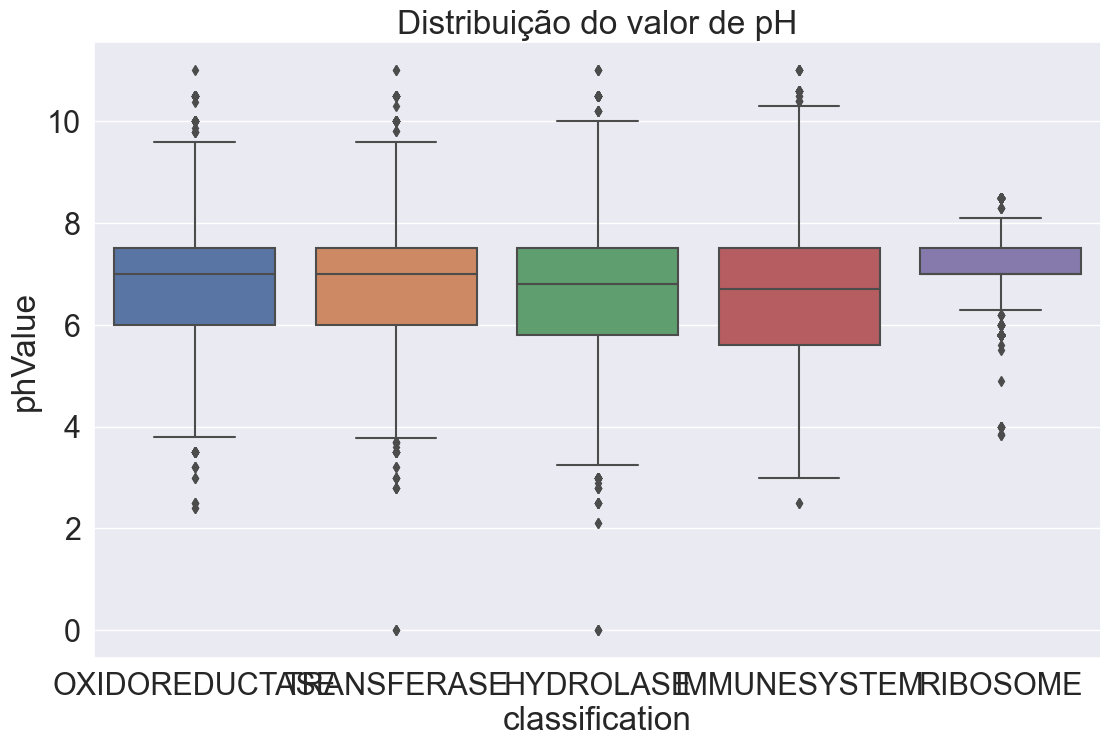

In [91]:
plt.figure(figsize=(13,8))
plt.title('Distribuição do valor de pH')
sns.boxplot(x=data_final['classification'], y=data_final['phValue'], orient='v')

# 06. Preparando o dataframe para treino e teste

In [92]:
# Transformando as classificações em valores numéricos
data_final['classification'].unique()

array(['OXIDOREDUCTASE', 'TRANSFERASE', 'HYDROLASE', 'IMMUNESYSTEM',
       'RIBOSOME'], dtype=object)

In [93]:
clases = {
    'OXIDOREDUCTASE':0, 
    'TRANSFERASE':1, 
    'HYDROLASE':2, 
    'IMMUNESYSTEM':3,
    'RIBOSOME':4
}

In [94]:
data_final['classification'] = data_final['classification'].map(clases)
data_final.head()

C:\Users\gusta\AppData\Local\Temp\ipykernel_6964\1368654941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['classification'] = data_final['classification'].map(clases)


,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationTempK,phValue
structureId,,,,,,
1A72,0,0,2.6,40658.50,277.0,8.40
1AR4,0,0,1.9,45428.53,277.0,6.10
1AR4,0,0,1.9,45428.53,277.0,6.10
1AR5,0,0,1.6,45430.34,277.0,6.15
1AR5,0,0,1.6,45430.34,277.0,6.15


In [95]:
x = data_final.drop(columns=['classification'])
y = data_final['classification']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)

In [97]:
def treinar_modelo(metodo, X_train, X_test, y_train, y_test):
    
    print("Quantidade de observações para treino:", X_train.shape[0])
    print("Quantidade de observações para teste:", X_test.shape[0])
    print(100*'-')

    modelo = metodo
    modelo_treinado = modelo.fit(X_train, y_train)
    print('Modelo treinado:', modelo_treinado)
    print(100*'-')

    print("Resultado de acurácia da classificação: %.2f%%" %(modelo_treinado.score(X_test,y_test)*100))
    print(100*'-')

    matriz_confusao = confusion_matrix(y_test,modelo_treinado.predict(X_test))
    plt.figure(figsize = (10, 8))
    plt.title('Matriz de confusão')
    sns.set(font_scale= 2)
    sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")
    plt.show()
    print(100*'-')

    previsoes = modelo_treinado.predict(X_test)
    print('\nClassification Report:')
    print(classification_report(y_test, previsoes))

# 07. Treinando e avaliando os primeiros modelos de classificação

Quantidade de observações para treino: 61077
Quantidade de observações para teste: 26177
----------------------------------------------------------------------------------------------------
Modelo treinado: DummyClassifier(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado de acurácia da classificação: 26.00%
----------------------------------------------------------------------------------------------------


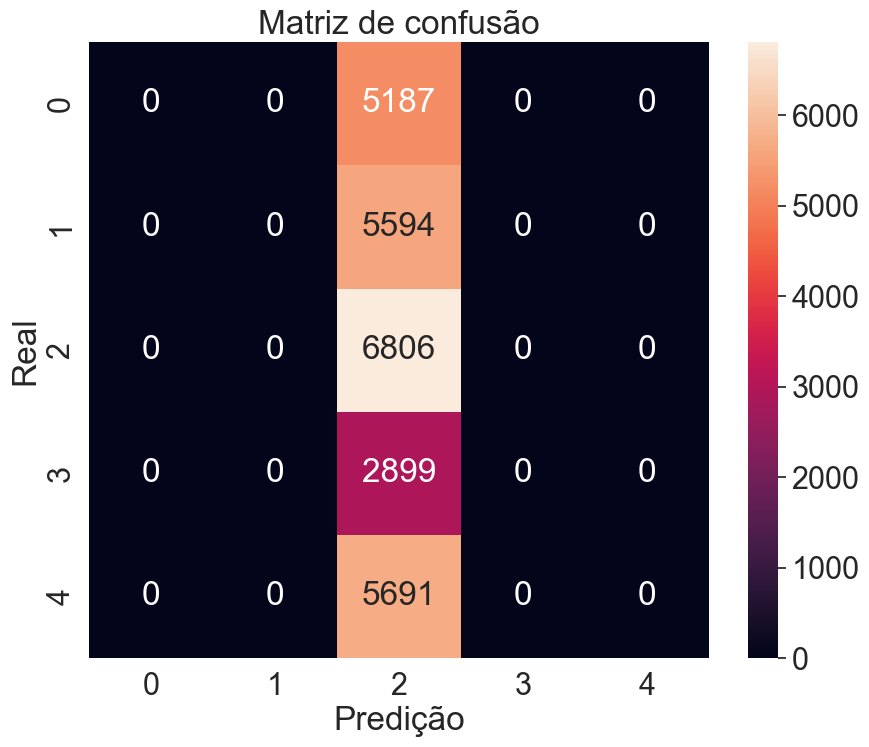

----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5187
           1       0.00      0.00      0.00      5594
           2       0.26      1.00      0.41      6806
           3       0.00      0.00      0.00      2899
           4       0.00      0.00      0.00      5691

    accuracy                           0.26     26177
   macro avg       0.05      0.20      0.08     26177
weighted avg       0.07      0.26      0.11     26177



c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [98]:
treinar_modelo(DummyClassifier(random_state=1337), X_train, X_test, y_train, y_test)

Quantidade de observações para treino: 61077
Quantidade de observações para teste: 26177
----------------------------------------------------------------------------------------------------
Modelo treinado: KNeighborsClassifier()
----------------------------------------------------------------------------------------------------
Resultado de acurácia da classificação: 74.54%
----------------------------------------------------------------------------------------------------


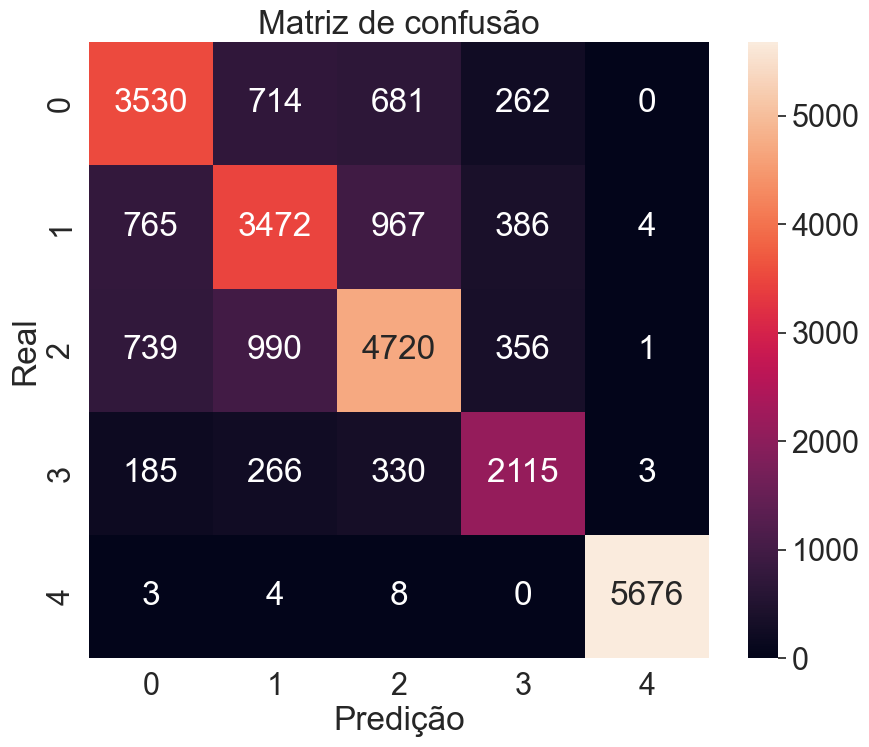

----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      5187
           1       0.64      0.62      0.63      5594
           2       0.70      0.69      0.70      6806
           3       0.68      0.73      0.70      2899
           4       1.00      1.00      1.00      5691

    accuracy                           0.75     26177
   macro avg       0.74      0.74      0.74     26177
weighted avg       0.75      0.75      0.75     26177



In [99]:
treinar_modelo(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

Quantidade de observações para treino: 61077
Quantidade de observações para teste: 26177
----------------------------------------------------------------------------------------------------
Modelo treinado: DecisionTreeClassifier(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado de acurácia da classificação: 91.23%
----------------------------------------------------------------------------------------------------


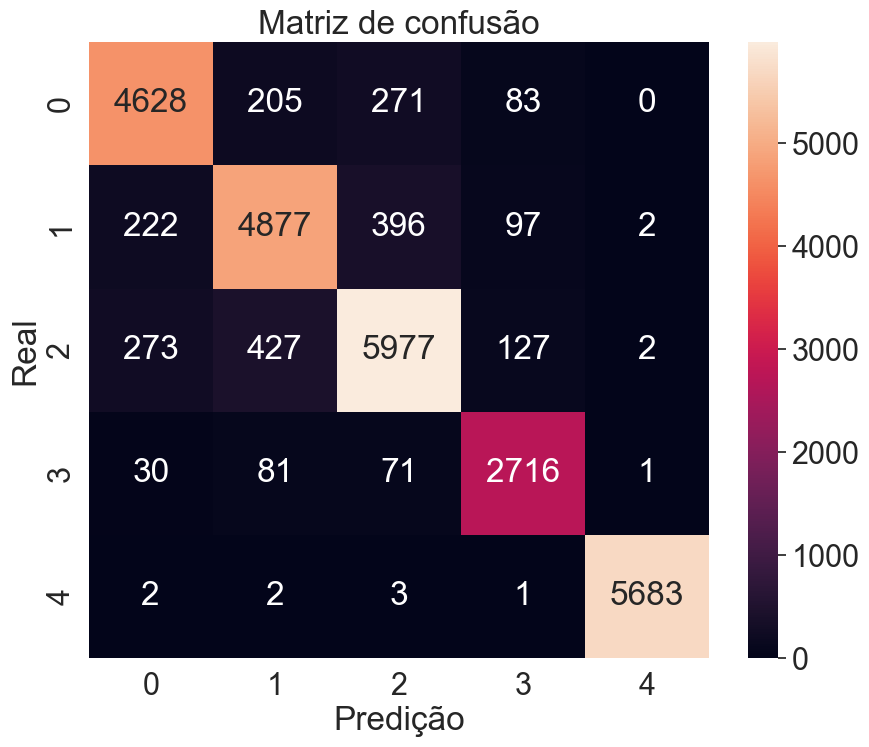

----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5187
           1       0.87      0.87      0.87      5594
           2       0.89      0.88      0.88      6806
           3       0.90      0.94      0.92      2899
           4       1.00      1.00      1.00      5691

    accuracy                           0.91     26177
   macro avg       0.91      0.92      0.91     26177
weighted avg       0.91      0.91      0.91     26177



In [100]:
treinar_modelo(DecisionTreeClassifier(random_state=1337), X_train, X_test, y_train, y_test)

Quantidade de observações para treino: 61077
Quantidade de observações para teste: 26177
----------------------------------------------------------------------------------------------------
Modelo treinado: GradientBoostingClassifier(random_state=1337)
----------------------------------------------------------------------------------------------------
Resultado de acurácia da classificação: 62.50%
----------------------------------------------------------------------------------------------------


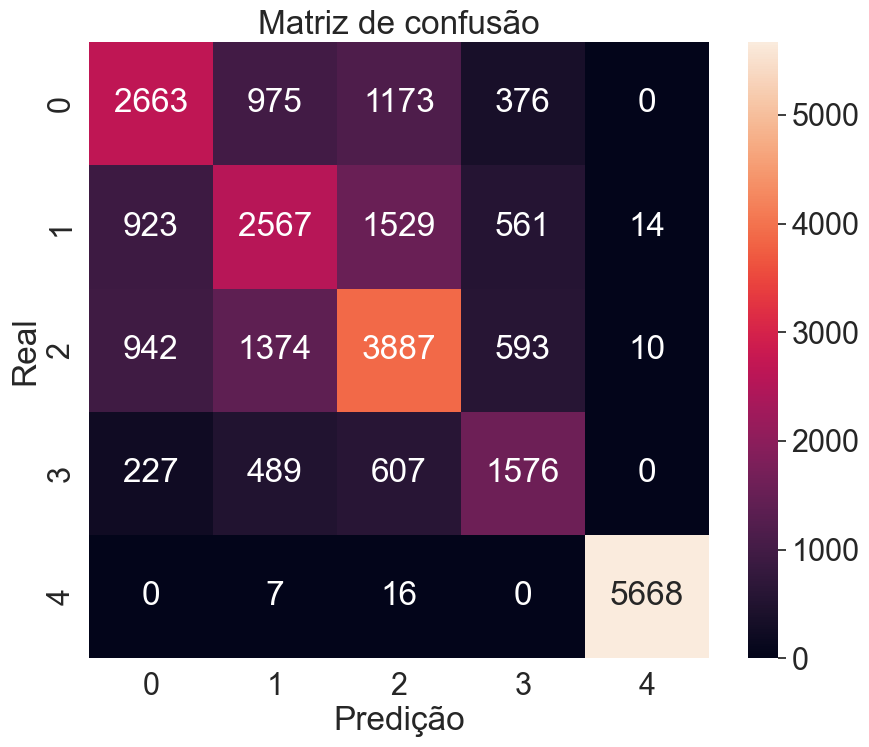

----------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.51      0.54      5187
           1       0.47      0.46      0.47      5594
           2       0.54      0.57      0.55      6806
           3       0.51      0.54      0.52      2899
           4       1.00      1.00      1.00      5691

    accuracy                           0.63     26177
   macro avg       0.62      0.62      0.62     26177
weighted avg       0.63      0.63      0.62     26177



In [101]:
treinar_modelo(GradientBoostingClassifier(random_state=1337), X_train, X_test, y_train, y_test)

Modelo campeão da primeira rodada de treino: *DecisionTreeClassifier*

# 08. Tunning do modelo

In [102]:
# Hiperparametros escolhidos
criterion = ['gini', 'entropy']
max_depth = [None, 1, 10, 30]
min_samples_split = list(range(2, 11))
min_samples_leaf = list(range(1, 6))
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

In [103]:
param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features,
    'class_weight': class_weight    
}

In [104]:
def otimizacao_parametros(modelo, params, n_splits, score_otimizacao, X, Y):
    # Encontra os melhores parâmetros
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=params,
        cv=KFold(n_splits=n_splits, shuffle=True),
        scoring=score_otimizacao,
        n_jobs=-1,
        refit=True
    )
    grid_fit = grid.fit(X, Y)
    best_parametros = grid_fit.best_params_
    best_score = grid_fit.best_score_
    best_model = grid_fit.best_estimator_

    return best_model, best_parametros, best_score

In [105]:
melhor_modelo, melhores_hiperparametros, melhor_score = otimizacao_parametros(
                                            modelo = DecisionTreeClassifier(random_state=1337), 
                                            params = param_grid,
                                            n_splits = 10,
                                            score_otimizacao= 'f1',
                                            X=x,
                                            Y=y)

c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [106]:
melhor_modelo

DecisionTreeClassifier(class_weight='balanced', max_features='auto',
                       random_state=1337)

In [107]:
melhores_hiperparametros

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

# 09. Salvando o modelo campeão

In [108]:
bestModel = melhor_modelo
bestModel.fit(X_train, y_train)

c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(class_weight='balanced', max_features='auto',
                       random_state=1337)

In [109]:
print("Modelo final:", bestModel)

previsoes = bestModel.predict(X_test)
print('\nClassification Report:')
print(classification_report(y_test, previsoes))

Modelo final: DecisionTreeClassifier(class_weight='balanced', max_features='auto',
                       random_state=1337)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5187
           1       0.88      0.87      0.87      5594
           2       0.88      0.87      0.88      6806
           3       0.89      0.95      0.92      2899
           4       1.00      1.00      1.00      5691

    accuracy                           0.91     26177
   macro avg       0.91      0.92      0.91     26177
weighted avg       0.91      0.91      0.91     26177



In [110]:
path_modelo = os.path.join(appPath, 'classificadorProteinas.pkl')

sav_best_model = open(path_modelo, 'wb')
pickle.dump(bestModel, sav_best_model)
sav_best_model.close()